In [ ]:
#import all required libaries
from keras.datasets import cifar10 
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model, Sequential 
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

from keras.models import load_model 
from keras.losses import msle
import numpy as np # linear algebra
import matplotlib.pyplot as plt #visualization library

In [ ]:
#load training and test dataset  from cifar10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [ ]:
# Concatenate train and test images
X = np.concatenate((X_train,X_test))
y = np.concatenate((Y_train,Y_test))


In [ ]:
print(X.shape)

(60000, 32, 32, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=1234)

In [ ]:
print(X_train.shape) 

(50000, 32, 32, 3)


In [ ]:

#load training and test dataset  from cifar10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Unit normalizing 
X_train = X_train.astype('float32')/255 
X_test = X_test.astype('float32')/255 
Y_test = Y_test.astype('float32')/255 
img_rows=X_train[0].shape[0]
img_cols=X_test[0].shape[1]
print(X_train.shape[0],img_rows,img_cols)
# Reshaping training and test datasets
X_train = X_train.reshape(len(X_train),X_train.shape[1],X_train.shape[2],3) 
# X_test = X_test.reshape(len(X_test),X_test.shape[1],X_test.shape[2],1) 
print(X_train.shape) #(50000, 32, 32, 3)
print(X_test.shape) #(10000, 32, 32, 3)
print(Y_test.shape) #(10000, 1)

170508288/170498071 [==============================] - 4s 0us/step
50000 32 32
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# preprocessing function
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image # dataset label is not used. replaced with the same image input.

# parameters
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024


### START CODE HERE (Replace instances of `None` with your code) ###

# use tfds.load() to fetch the 'train' split of CIFAR-10
train_dataset = tfds.load('cifar10', as_supervised = True, split = 'train')

# preprocess the dataset with the `map_image()` function above
train_dataset = train_dataset.map(map_image)

# shuffle and batch the dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()


# use tfds.load() to fetch the 'test' split of CIFAR-10
test_dataset = tfds.load('cifar10', as_supervised = True, split = 'test')

# preprocess the dataset with the `map_image()` function above
test_dataset = test_dataset.map(map_image)

# batch the dataset
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

In [ ]:

# reshaped = np.reshape(Y_test,(-1,1))
# random = (np.random.uniform(low=0, high=len(reshaped), size=10000))
# # reduced = reshaped- 153599000
# print(random.shape)
# print(Y_test.reshape(10000,32,32,1))

In [ ]:
def build_autoencoder(img_shape):
    # The encoder network
    encoder = Sequential()
    encoder.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=img_shape)) # 32x32x32
    encoder.add(BatchNormalization()) # 32x32x32
    encoder.add(MaxPooling2D(2, padding='same')) # 16x16x32
    encoder.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu'))  # 16x16x16
    encoder.add(BatchNormalization())  # 16x16x16
    encoder.add(Conv2D(8, kernel_size=3, strides=1, padding='same', activation='relu')) # 16x16x8
    encoder.add(BatchNormalization()) # 16x16x8
    encoder.add(Conv2D(8, kernel_size=3, strides=1, padding='same', activation='relu')) # 16x16x8
    
    # The decoder network
    decoder = Sequential()
    decoder.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')) # 16x16x32
    decoder.add(BatchNormalization()) # 16x16x32
    decoder.add(UpSampling2D()) # 32x32x32
    decoder.add(Conv2D(16, kernel_size=3, strides=2, padding='same', activation='relu')) # 16x16x16
    decoder.add(BatchNormalization()) # 16x16x16
    decoder.add(UpSampling2D()) # 32x32x16
    decoder.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')) # 32x32x16
    decoder.add(BatchNormalization()) # 32x32x16
    decoder.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid')) # 32x32x3
    
    return encoder, decoder

In [ ]:
# IMG_SHAPE =  X_train.shape[1:] #(32, 32, 3)
IMG_SHAPE =  X_train.shape[1:] 
input_img = Input(shape=IMG_SHAPE) #create image input
encoder, decoder = build_autoencoder(IMG_SHAPE)
code = encoder(input_img) #encode image
reconstruction = decoder(code) #decoder image
autoencoder = Model(input_img,reconstruction) #create autoencoder model
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error') # compile model using adam optimizer and measure loss using mean_squared_error
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
                                                        

In [ ]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=200)

In [ ]:
# modelcheckpoint stores the weights best weights in a model with an interrval for futurue use
mc = ModelCheckpoint('auto_encoder_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
#trains model with fixed number of epochs 
# history = autoencoder.fit(x=X_train, y=X_train,
#                 validation_data=[X_test, X_test], batch_size=32, epochs=400)

# history = autoencoder.fit(x=X_train, y=X_train,
#                 validation_data=[X_test, X_test],  epochs=300, callbacks=[es, mc])
# history = autoencoder.fit(x=X_train, y=X_train,
#                 validation_data=[X_test, X_test],  epochs=200, callbacks=[es, mc])
history = autoencoder.fit(x=X_train, y=X_train,
                validation_data=[X_test, X_test], batch_size=32, epochs=100)
# parameters (feel free to change this)
# train_steps = 50000 // BATCH_SIZE 
# val_steps = 10000 // BATCH_SIZE

### START CODE HERE ###
# history = autoencoder.fit(train_dataset, steps_per_epoch = train_steps, validation_data = test_dataset, validation_steps = val_steps, epochs = 200, callbacks=[es, mc])

Epoch 1/100
1563/1563 [==============================] - 21s 6ms/step - loss: 0.0058 - accuracy: 0.6694 - val_loss: 0.0024 - val_accuracy: 0.7782
Epoch 2/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0022 - accuracy: 0.7815 - val_loss: 0.0015 - val_accuracy: 0.8141
Epoch 3/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0017 - accuracy: 0.8047 - val_loss: 0.0013 - val_accuracy: 0.8056
Epoch 4/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0015 - accuracy: 0.8112 - val_loss: 9.2430e-04 - val_accuracy: 0.8257
Epoch 5/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0014 - accuracy: 0.8135 - val_loss: 0.0015 - val_accuracy: 0.8188
Epoch 6/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0013 - accuracy: 0.8174 - val_loss: 8.6769e-04 - val_accuracy: 0.8299
Epoch 7/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0013 - accuracy: 0.8200 - val_loss: 0.0011

In [ ]:
# print(X_test.shape)
# print(Y_test.shape)
# print(y_train.shape)
# print(X_train.shape)
decoded_imgs = autoencoder.predict(X_test)
_, acc  = autoencoder.evaluate(decoded_imgs, X_test, steps=10)
print('> %.3f' % (acc * 100.0))
# autoencoder.evaluate(test_dataset, steps=1)

10/10 [==============================] - 1s 27ms/step - loss: 8.7186e-04 - accuracy: 0.8397
> 83.968


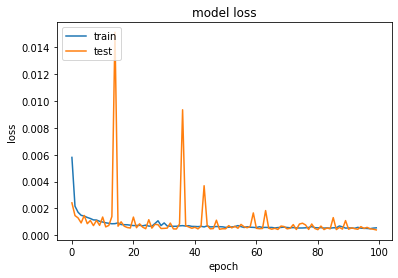

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

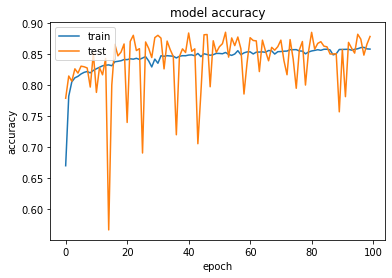

In [ ]:
#accuracy between train and test data  based on training results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_pred = autoencoder.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))

157/157 [==============================] - 1s 3ms/step


NameError: ignored

In [ ]:
bestautoencoder = load_model("best_model.h5")
decoded_imgs = bestautoencoder.predict(X_test)
_, acc  = bestautoencoder.evaluate(decoded_imgs, X_test)
# print('> %.3f' % (acc * 100.0))
# print(decoded_imgs.shape)

313/313 [==============================] - 1s 4ms/step - loss: 8.6279e-04 - accuracy: 0.8722


In [ ]:
print(decoded_imgs.shape)

(10000, 32, 32, 3)


In [ ]:
print(decoded_imgs[1])

[[[0.92870545 0.92070585 0.9248937 ]
  [0.90702856 0.9079155  0.8983113 ]
  [0.9036635  0.89424497 0.8884696 ]
  ...
  [0.898682   0.89016134 0.88687724]
  [0.91082084 0.8982347  0.9039571 ]
  [0.93471915 0.9109461  0.92200875]]

 [[0.9317786  0.9262494  0.9273983 ]
  [0.89937365 0.9043631  0.8991843 ]
  [0.90345067 0.8977963  0.8987373 ]
  ...
  [0.9210368  0.9060453  0.9060253 ]
  [0.93415266 0.91284966 0.9151025 ]
  [0.92782533 0.90814304 0.9144967 ]]

 [[0.92745227 0.9176869  0.92282355]
  [0.90904045 0.90851796 0.9097994 ]
  [0.9109687  0.9070897  0.9128296 ]
  ...
  [0.9257281  0.9204874  0.9127279 ]
  [0.93777066 0.9276897  0.92721933]
  [0.92973113 0.91712266 0.918452  ]]

 ...

 [[0.35085183 0.38220376 0.32928032]
  [0.17585526 0.21378899 0.16165625]
  [0.04918306 0.06551577 0.04668919]
  ...
  [0.67401254 0.72403604 0.6993994 ]
  [0.71990895 0.772181   0.761191  ]
  [0.7377868  0.794887   0.78109854]]

 [[0.33217666 0.37278256 0.31494972]
  [0.17375642 0.22835025 0.14241877]


In [ ]:
rounded_labels=np.argmax(Y_train, axis=1) 
print(rounded_labels.shape)
print(np.argmax(decoded_imgs, axis=1).shape)

(1,)
(10000, 32, 3)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

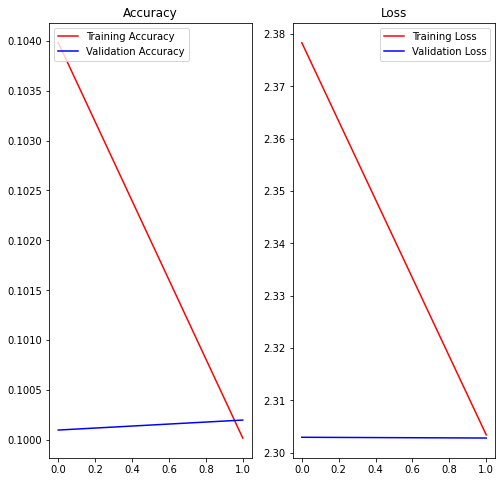

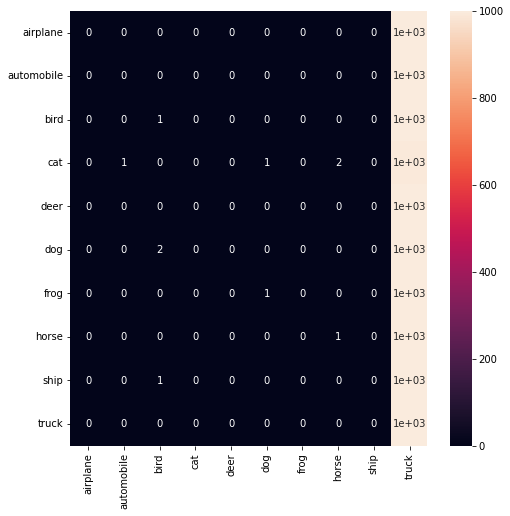

In [ ]:
import tensorflow as tf 

from tensorflow import keras 
import matplotlib.pyplot as plt 

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

input_shape = train_images.shape[1:]

model  = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32 , 3, activation="relu" , input_shape = input_shape))
model.add(tf.keras.layers.Conv2D(32 , 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64 , 3, activation="relu"))
model.add(tf.keras.layers.Conv2D(64 , 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())



model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1024, activation = "relu"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

model.compile(
    optimizer = tf.keras.optimizers.Adam() , 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics = ["accuracy"]
)

model.summary()
epochs = 2
history  =  model.fit(
    train_images, 
    train_labels, 
    validation_data = (test_images, test_labels),
    epochs = epochs
)


plt.figure(figsize = (8,8))

plt.subplot(1,2,1)
plt.plot(range(epochs) , history.history["accuracy"] , "r" , label = "Training Accuracy")
plt.plot(range(epochs) , history.history["val_accuracy"] , "b" , label = "Validation Accuracy")
plt.legend(loc="upper left")
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(range(epochs) , history.history["loss"] , "r" , label = "Training Loss")
plt.plot(range(epochs) , history.history["val_loss"] , "b" , label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Loss")

plt.show()


predictions  = model.predict(test_images)

#The following 7 lines are all that is required to plot the confusion matrix.
predictions_for_cm = predictions.argmax(1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

cm = confusion_matrix(test_labels,predictions_for_cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,  xticklabels=class_names, yticklabels = class_names)


In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
y_true = np.array([[1, 0, 1, 0, 0],
                   [0, 1, 0, 1, 1],
                   [1, 1, 1, 0, 1]])
y_pred = np.array([[1, 0, 0, 0, 1],
                   [0, 1, 1, 1, 0],
                   [1, 1, 1, 0, 0]])

print(y_true.shape, y_pred.shape)

multilabel_confusion_matrix(y_true, y_pred)
# result:


(3, 5) (3, 5)


array([[[1, 0],
        [0, 2]],

       [[1, 0],
        [0, 2]],

       [[0, 1],
        [1, 1]],

       [[2, 0],
        [0, 1]],

       [[0, 1],
        [2, 0]]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         2

   micro avg       0.75      0.67      0.71         9
   macro avg       0.70      0.70      0.70         9
weighted avg       0.67      0.67      0.67         9
 samples avg       0.72      0.64      0.67         9



In [ ]:
decoded_imgs.shape

(10000, 32, 32, 3)

In [ ]:
pred_x_train = decoded_imgs.reshape(10000, 32*32*3)
pred_x_train.shape

(10000, 3072)

In [ ]:
bestautoencoder.predict(bestautoencoder)

ValueError: ignored

In [ ]:
pred = np.argmax(Y_test, axis=1)

In [ ]:
print(pred.shape)

(10000,)


In [ ]:
y_train = np.argmax(Y_test, axis=1)

In [ ]:
print(y_train.shape)

(10000,)


In [ ]:
confusion_matrix(y_train, decoded_imgs)

ValueError: ignored

In [ ]:
predictions_for_cm = decoded_imgs.argmax(1)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog", "horse", "ship", "truck"]

In [ ]:
print()

In [ ]:
cm = confusion_matrix(Y_test,predictions_for_cm)
plt.figure(figsize=(8,8))
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,  xticklabels=class_names, yticklabels =class_names)

ValueError: ignored

In [ ]:
mse = np.mean(np.power(X_test - decoded_imgs, 2), axis=1)

In [ ]:
print(mse)

[[[4.08046151e-04 4.50490712e-04 5.66948263e-04]
  [5.47272037e-04 6.12720090e-04 7.31761742e-04]
  [4.52380744e-04 4.41828830e-04 5.10232989e-04]
  ...
  [3.14778677e-04 2.20711372e-04 4.18112468e-04]
  [3.60628299e-04 1.85330267e-04 2.44902563e-04]
  [2.92867917e-04 1.87055703e-04 6.82318234e-04]]

 [[4.97223635e-04 7.06350955e-04 7.45736470e-04]
  [5.91795251e-04 4.93424013e-04 4.46690130e-04]
  [4.40889416e-04 5.45990479e-04 3.94802191e-04]
  ...
  [1.62992786e-04 1.27160485e-04 1.56887632e-04]
  [9.89162727e-05 1.26292420e-04 1.02888291e-04]
  [1.42667341e-04 1.04038321e-04 1.04017949e-04]]

 [[2.66870920e-04 4.40786971e-04 3.19284736e-04]
  [2.05451957e-04 1.81956304e-04 1.24376165e-04]
  [2.32666178e-04 2.32693288e-04 2.66712130e-04]
  ...
  [4.22840822e-04 4.24026133e-04 3.53592884e-04]
  [2.46538955e-04 2.45117699e-04 3.38522106e-04]
  [2.59413762e-04 2.55156658e-04 4.58134280e-04]]

 ...

 [[6.27223417e-05 2.00715112e-05 6.95772906e-05]
  [7.20494863e-05 2.31554241e-05 2.9669

In [ ]:
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

In [ ]:
# Initialize SVM classifier
clf = svm.SVC(kernel='linear')

In [ ]:
#  X_train = (X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))
#  Y_train = (Y_train.reshape(Y_train.shape[0], Y_train.shape[1] * Y_train.shape[2] * Y_train.shape[3]))
print(X_train.shape)
print(Y_train.shape)

(50000, 3072)
(50000, 1)


In [ ]:
print(X_train.reshape(1,-1))

[[0.23137255 0.24313726 0.24705882 ... 0.6392157  0.6392157  0.6313726 ]]


In [ ]:
print(X_train.reshape(1,-1).shape)

(1, 153600000)


In [ ]:
print(Y_train.reshape(1,-1))

[[6 9 9 ... 9 1 1]]


In [ ]:
print(Y_train.reshape(1,-1).shape)

(1, 50000)


In [ ]:
X_train = X_train.reshape(1,-1)
Y_train = Y_train.reshape(1,-1)

In [ ]:
clf = clf.fit(X_train, Y_train)

ValueError: ignored

In [ ]:
autoencoder.save("best_model_3.h5")

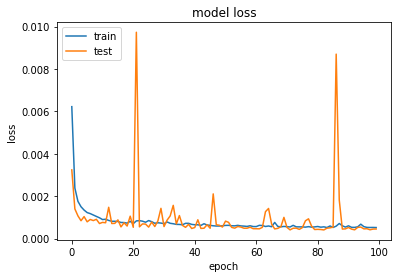

In [ ]:
#loss between train and test data  based on training results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

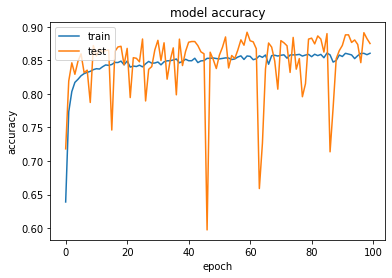

In [ ]:
#accuracy between train and test data  based on training results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

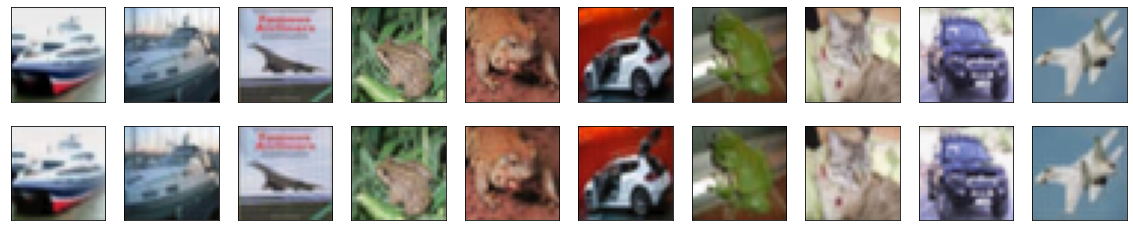

In [ ]:
#for 10 results based on the model
decoded_imgs = autoencoder.predict(X_test) 
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.evaluate(X_test, Y_test)
# autoencoder.summary()

303/313 [============================>.] - ETA: 0s - loss: 24.4922 - accuracy: 0.4816

InvalidArgumentError: ignored

In [ ]:
#find thershold
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold, reconstructions

In [ ]:
threshold, reconstructions = find_threshold(autoencoder, X_train)


In [ ]:
print(threshold)

0.0013110957


In [ ]:
import pandas as pd
def get_predictions(reconstructions, x_test_scaled, threshold):
  predictions = reconstructions
  # model.evaluate(predictions, Y_test)
  print(predictions.shape)
  print(predictions.flatten)
  autoencoder.evaluate(x_test_scaled, Y_train)
  # provides losses of individual instances
  # errors = msle(predictions, x_test_scaled)
  # print(errors)
  # 0 = anomaly, 1 = normal
  # anomaly_mask = pd.Series(errors) > threshold
  # preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  preds = 0
  return preds

In [ ]:
predictions = get_predictions(reconstructions, X_train, threshold)

(50000, 32, 32, 3)
<built-in method flatten of numpy.ndarray object at 0x7fded59b8ed0>
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0031 - accuracy: 0.6809


In [ ]:
#import metrics to measure the quality of results
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
def calculate_mse(imageA, imageB):
	return mse(imageA, imageB)

def calculate_psnr(imageA, imageB):
	return psnr(imageA, imageB)

def calculate_ssim(imageA, imageB):
	return ssim(imageA, imageB, multichannel=True)

def compression_ratio(original, compressed):
	return (original.size) / (compressed.size)

def compare_images(original, compressed, title):
	# compute the mean squared error, peak signal noise ratio and structural similarity
	fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True,sharey=True)
	ax = axes.ravel()
	cal_mse = calculate_mse(original,compressed)
	cal_psnr = calculate_psnr(original,compressed)
	cal_ssim = calculate_ssim(original,compressed)
	# setup the figure
	ax[0].imshow(original, cmap=plt.cm.gray)
	ax[0].set_xlabel(f'MSE: {calculate_mse(original,original):.4f}, SSIM: {calculate_ssim(original,original):.3f}')
	ax[0].set_title('Original image')

	ax[1].imshow(compressed, cmap=plt.cm.gray)
	ax[1].set_xlabel(f'MSE: {cal_mse:.4f}, PSNR: {cal_psnr:.3f}, SSIM: {cal_ssim:.3f}')
	ax[1].set_title('Compressed image')
  # plt.savefig("Compressed_{date}")
	plt.show()
  # plt.savefig("Compressed_{date}")

In [ ]:
worstautoencoder = load_model("worst_model.h5")

In [ ]:
bestencoder = load_model("best_model.h5")

In [ ]:
# decoded_worst_imgs  = worstautoencoder.predict(X_test)
decoded_best_imgs = bestencoder.predict(X_test)

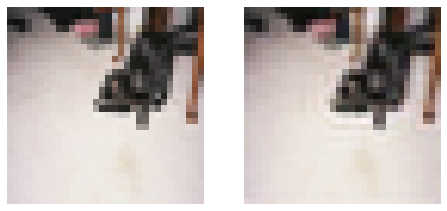

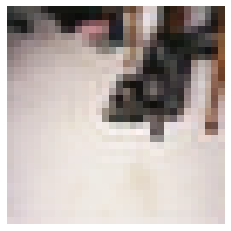

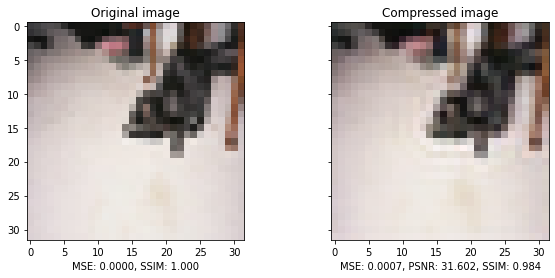

1.0000


In [ ]:
# test quality results with random images
# initialize the figure
fig = plt.figure("Images",figsize=(12,10))
index  = np.random.randint(len(X_test))
original = np.squeeze(X_test[index])
compressed = np.squeeze(decoded_best_imgs[index])
images = ("Original", original), ("Reconstructed", compressed)
# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image

	ax = fig.add_subplot(1, 3, i + 1)
	# ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")
# show the figure
plt.show()

plt.imshow(original)
plt.axis('off')
# plt.title( "An 8x8 Image block")
plt.savefig("Original")

plt.imshow(compressed)
plt.axis('off')
# plt.title( "An 8x8 Image block")
plt.savefig("Reconstructed")

#compare image quality
compare_images(original, compressed, "Original vs. Compressed")

#calculate compression ratio
cr = "{:.4f}".format(compression_ratio(original, compressed))
print(cr)

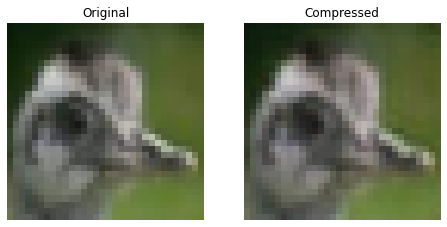

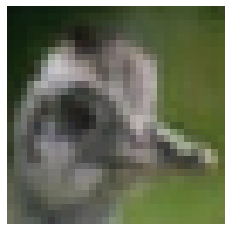

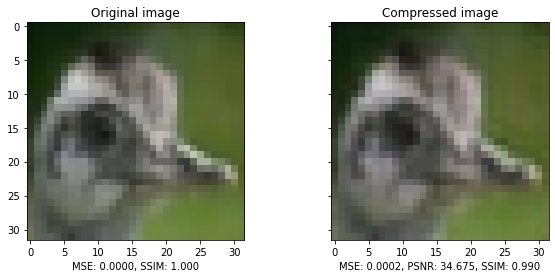

1.0000


In [ ]:
# test quality results with random images
# initialize the figure
fig = plt.figure("Images",figsize=(12,10))
original = np.squeeze(X_test[index])
compressed = np.squeeze(decoded_worst_imgs[index])
images = ("Original", original), ("Compressed", compressed)
# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image

	ax = fig.add_subplot(1, 3, i + 1)
	ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")
# show the figure
plt.show()

plt.imshow(original)
plt.axis('off')
# plt.title( "An 8x8 Image block")
plt.savefig("Original")

plt.imshow(compressed)
plt.axis('off')
# plt.title( "An 8x8 Image block")
plt.savefig("Compressed")

#compare image quality
compare_images(original, compressed, "Original vs. Compressed")

#calculate compression ratio
cr = "{:.4f}".format(compression_ratio(original, compressed))
print(cr)

In [ ]:
# add some gaussian noise 
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

In [ ]:
worstautoencoder = load_model("worst_model.h5")

In [ ]:
bestautoencoder = load_model("best_model.h5")

In [ ]:
for i in range(30):
    print("Epoch %i/30, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test])

Epoch 1/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0023 - accuracy: 0.7646 - val_loss: 0.0022 - val_accuracy: 0.7695
Epoch 2/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0022 - accuracy: 0.7710 - val_loss: 0.0021 - val_accuracy: 0.7906
Epoch 3/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0021 - accuracy: 0.7729 - val_loss: 0.0022 - val_accuracy: 0.7861
Epoch 4/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0021 - accuracy: 0.7724 - val_loss: 0.0020 - val_accuracy: 0.7855
Epoch 5/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0021 - accuracy: 0.7737 - val_loss: 0.0022 - val_accuracy: 0.7873
Epoch 6/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0021

In [ ]:
bestautoencoder.save("best_model_sigma_1.h5")

In [ ]:
autoencoder = load_model("best_model_sigma_1.h5")

In [ ]:
X_test_noise = apply_gaussian_noise(X_test)
n = 10
decoded_imgs = autoencoder.predict(X_test_noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

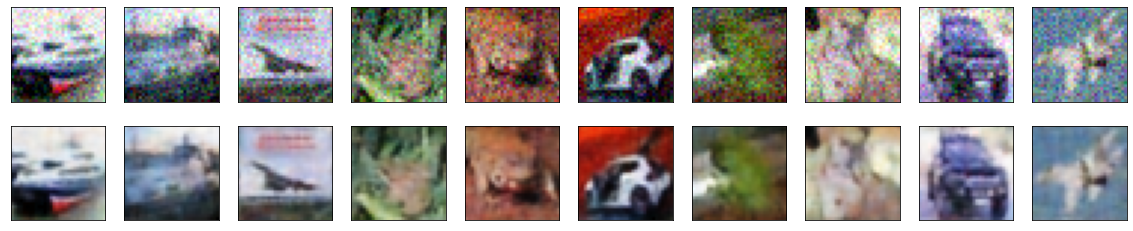

In [ ]:
X_test_noise = apply_gaussian_noise(X_test)
n = 10
decoded_imgs = bestautoencoder.predict(X_test_noise)
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_noise[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
_, acc  = autoencoder.evaluate(decoded_imgs, X_test_noise)
print('> %.3f' % (acc * 100.0))
print(decoded_imgs.shape)

313/313 [==============================] - 1s 3ms/step - loss: 0.0116 - accuracy: 0.5617
> 56.169
(10000, 32, 32, 3)


In [ ]:
#import metrics to measure the quality of results
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
def calculate_mse(imageA, imageB):
	return mse(imageA, imageB)

def calculate_psnr(imageA, imageB):
	return psnr(imageA, imageB, data_range=imageA.max() - imageA.min())

def calculate_ssim(imageA, imageB):
	return ssim(imageA, imageB, multichannel=True)

def compression_ratio(original, compressed):
	return (original.size) / (compressed.size)

def compare_images(original, compressed, title):
	# compute the mean squared error, peak signal noise ratio and structural similarity
	fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True,sharey=True)
	ax = axes.ravel()
	cal_mse = calculate_mse(original,compressed)
	cal_psnr = calculate_psnr(original,compressed)
	cal_ssim = calculate_ssim(original,compressed)
	# setup the figure
	ax[0].imshow(original, cmap=plt.cm.gray)
	ax[0].set_xlabel(f'MSE: {calculate_mse(original,original):.4f}, SSIM: {calculate_ssim(original,original):.3f}')
	ax[0].set_title('Original image')

	ax[1].imshow(compressed, cmap=plt.cm.gray)
	ax[1].set_xlabel(f'MSE: {cal_mse:.4f}, PSNR: {cal_psnr:.3f}, SSIM: {cal_ssim:.3f}')
	ax[1].set_title('Compressed image')
  # plt.savefig("Compressed_{date}")
	plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


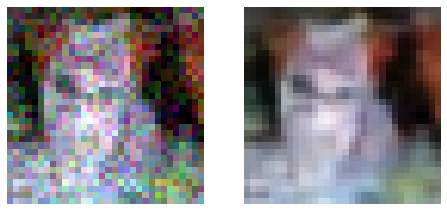

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


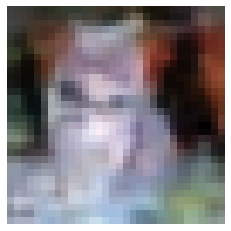

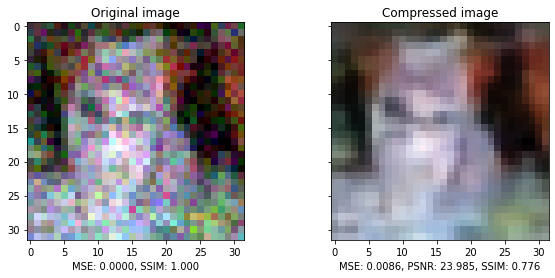

1.0000


In [ ]:
# test quality results with random images
# initialize the figure
fig = plt.figure("Images",figsize=(12,10))
index  = np.random.randint(len(X_test_noise))
original = np.squeeze(X_test_noise[index])
compressed = np.squeeze(decoded_imgs[index])
images = ("Original", original), ("Compressed", compressed)
# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image

	ax = fig.add_subplot(1, 3, i + 1)
	# ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")
# show the figure
plt.show()

plt.imshow(original)
plt.axis('off')
# plt.title( "An 8x8 Image block")
plt.savefig("Original")

plt.imshow(compressed)
plt.axis('off')
# plt.title( "An 8x8 Image block")
plt.savefig("Compressed")

#compare image quality
compare_images(original, compressed, "Original vs. Compressed")

#calculate compression ratio
cr = "{:.4f}".format(compression_ratio(original, compressed))
print(cr)